In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/home/scidb/HeartRatePatterns/Python"))
from LogisticRegresion import ajustLogisticRegression
from PlotWords import plot_word
from Matrix import convert_matrix
from NMF import generateNMF,auc_model,find_best_NMF

In [2]:
def findpatient(message,table,beats):
    groupsize = table.shape[0]
    deads = sum(table.index.labels[1].tolist())
    percent = -1 if groupsize==0 else deads/groupsize
    if groupsize!=0:
        print(message,"groupsize:%d"%groupsize,"deads:%d"%deads,"percent:{0:.2%}".format(percent),beats)

In [3]:
import psycopg2
def selectPearson(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='SELECT patient,deadpatient,p1 FROM wordspearson WHERE word = %s'
#    print(cur.mogrify(select_statement,locals()))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        patient=row[0]
        select = {'word':word,"pacientes":patient,"porcentaje de muertos":"{0:.2%}".format(row[1]/patient),"p1":row[2]}
    cur.close()
    conn.close()
    return select

In [4]:
def print_top_words(model, feature_names,topic_index=None):
    result = []
    for topic_idx, topic in enumerate(components):
        features = [{"word":feature_names[i],"p1":topic[i]} 
                    for i in topic.argsort()[:-1] if topic[i] > 0]
        if features!=[] and (topic_index==None or topic_index==topic_idx): result.append({"topic":topic_idx,"features":features})
    return result

In [5]:
def addValue(key,my_dict):
    if key in my_dict:
        my_dict[key] += 1
    else:
        my_dict[key] = 1
    return my_dict

In [6]:
table = convert_matrix(with_pearson=True) #.iloc[:,:400]
survived = table.index.labels[1].tolist()
patients = table.values
table

(554, 400)


,,aaadc,aabadd,aabaf,aabafb,aabaga,aabbg,aabbgb,aabdab,aabdad,aabdb,...,hag,haj,hbf,hdd,hddd,hfa,hfg,hga,hgd,jag
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
135,1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,0,1,0,0,2,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
177,1,0,0,0,0,0,0,0,1,0,7,...,0,0,0,0,0,0,0,0,0,0
214,1,0,0,2,0,1,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
263,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
279,1,0,0,0,0,0,0,0,1,0,6,...,0,0,0,0,0,0,0,0,0,0
283,1,0,1,0,0,0,0,0,2,0,2,...,0,0,0,0,0,0,0,0,0,0
368,1,0,0,1,1,1,1,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0
377,1,1,1,2,1,3,0,0,8,2,16,...,0,0,0,1,1,1,0,0,0,0


In [7]:
from sklearn.model_selection import train_test_split
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)

In [8]:
model,acurracy = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)
logit_roc_auc = auc_model("Logistic",model,patients_test,survived_test)

acurracy is 70.27%
Logistic AUC = 0.4632f


In [9]:
def countPatients(word,dbname="mimic") :
    conn = psycopg2.connect("dbname="+dbname)
    cur = conn.cursor()
    select_statement='''SELECT count(1),sum(isalive) FROM matrix m LEFT JOIN subjectwords s 
    ON m.subject_id=s.subject_id where m.word = %s GROUP BY m.word'''
#    print(cur.mogrify(select_statement,(word,)))
    cur.execute(select_statement,(word,))
    select = {}
    for row in cur :
        select = {"patient":row[0],"deadPatient":row[1],}
    cur.close()
    conn.close()
    return select

In [13]:
from scipy.stats.stats import pearsonr
columns = list(table.columns.values)
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    word = columns[i]
    count = countPatients(word)
    deadPatient,patient = count['deadPatient'],count['patient']
    percent = deadPatient/patient
    pearsonList.append({'word':word,'correlación':pearson[0],'p-valor':pearson[1],'pacientes muertos':"{0:.2%}".format(percent)+" de %d" %patient})

In [14]:
from operator import itemgetter
pearsonList = sorted(pearsonList, key=itemgetter('correlación'), reverse=True)
pearsonList
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df = pd.DataFrame(pearsonList)
df = df.set_index('word')
df = df.sort_values(['correlación'], ascending=[False])
df

,correlación,p-valor,pacientes muertos
word,,,
babaaf,0.14448,0.00065,90.11% de 91
babaf,0.13705,0.00122,84.00% de 150
ababaf,0.13675,0.00125,90.10% de 101
abbg,0.13498,0.00145,86.57% de 134
fbabd,0.13318,0.00168,97.44% de 39
abaf,0.13287,0.00172,81.18% de 287
dafaab,0.13162,0.00191,95.35% de 43
bababf,0.13056,0.00207,87.36% de 87
fbbaba,0.12763,0.00262,89.47% de 95


acurracy is 78.38%
NMF 2 AUC = 0.5002f
pearson 0.0537649203283
acurracy is 78.38%
NMF 3 AUC = 0.5002f
pearson 0.0970548800057
acurracy is 78.38%
NMF 4 AUC = 0.5002f
pearson 0.0900181934643
acurracy is 78.38%
NMF 5 AUC = 0.5002f
pearson 0.0815622793441
acurracy is 78.38%
NMF 6 AUC = 0.5002f
pearson 0.0796729240204
acurracy is 78.38%
NMF 7 AUC = 0.5002f
pearson 0.127376250873
acurracy is 78.38%
NMF 8 AUC = 0.5002f
pearson 0.127157220215
acurracy is 76.58%
NMF 9 AUC = 0.4892f
pearson 0.123638781336
acurracy is 75.68%
NMF 10 AUC = 0.4832f
pearson 0.122206562747
acurracy is 75.68%
NMF 11 AUC = 0.4832f
pearson 0.0990535043886
acurracy is 75.68%
NMF 12 AUC = 0.4832f
pearson 0.0990853644751
acurracy is 75.68%
NMF 13 AUC = 0.4982f
pearson 0.102467314415
acurracy is 77.48%
NMF 14 AUC = 0.4942f
pearson 0.108840348973
acurracy is 76.58%
NMF 15 AUC = 0.5042f
pearson 0.0900318141107
acurracy is 75.68%
NMF 16 AUC = 0.4832f
pearson 0.102026135242
acurracy is 75.68%
NMF 17 AUC = 0.4832f
pearson 0.10122

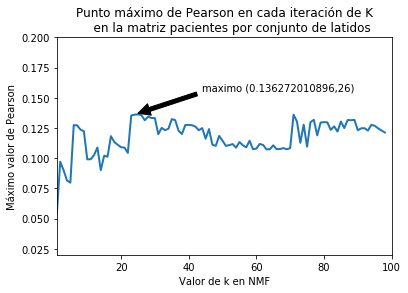

In [15]:
modelnmf, bestNmf, patientnmf, accuracyScore, p1, bestScore = find_best_NMF(patients,survived)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.00978107,  0.        ,  0.28121006, ...,  0.        ,
         0.02307923,  0.        ],
       [ 0.03599344,  0.        ,  0.        , ...,  0.51992731,
         0.        ,  0.23137692],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.00670419,
         0.01140649,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.02832594,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [16]:
from sklearn.metrics import classification_report
print("bestScore "+str(bestScore)+" accurracy is %2.2f"% accuracyScore)
print(classification_report(survived,modelnmf.predict(patientnmf)))

bestScore 26 accurracy is 0.76
             precision    recall  f1-score   support

          0       0.61      0.08      0.14       136
          1       0.77      0.98      0.86       418

avg / total       0.73      0.76      0.69       554



In [17]:
import numpy as np
compoT = np.transpose(bestNmf.components_)
print("components",bestNmf.components_.shape)
print("components Transpose",compoT.shape)

components (26, 400)
components Transpose (400, 26)


In [18]:
from operator import itemgetter
def predict_proba(compoT,table):
    predicts = modelnmf.predict_proba(compoT)[:,1]
    beats = list(table)
    sortedBeats = []
    numPred = len(predicts)
    print(len(beats),numPred)
    nvals={}
    for i in range(0,numPred):
        word = beats[i]
        sel = selectPearson(word)
        if sel=={}:
            print("palabra no encontrada en pearson:",word)
        sortedBeats.append({'word':beats[i],'predict':predicts[i],'pacientes':sel['pacientes'],
                            'porcentaje de muertos':sel['porcentaje de muertos'],"correlación":sel['p1']})
        if predicts[i]>.99 : addValue("99",nvals)
        elif predicts[i]>.90 : addValue("90",nvals)
        elif predicts[i]>.80 : addValue("80",nvals)
        elif predicts[i]>.70 : addValue("70",nvals)
        else: addValue("under",nvals)
    print(nvals)
    return sorted(sortedBeats, key=itemgetter('correlación'), reverse=True)

In [19]:
sortedBeats = predict_proba(compoT,table)
beatKeys = []
for value in sortedBeats:
    beatKeys.append(value['word'])

400 400
{'99': 147, 'under': 40, '80': 54, '70': 44, '90': 115}


In [20]:
df = pd.DataFrame(sortedBeats)
df = df.set_index('word')
df = df.sort_values(['correlación'], ascending=[False])
df

,correlación,pacientes,porcentaje de muertos,predict
word,,,,
adc,0.20889,155,89.68%,0.99897
fdf,0.20378,83,96.39%,1.00000
dbda,0.18907,221,85.07%,0.99956
fbd,0.18370,165,87.27%,0.99773
dff,0.18014,88,93.18%,1.00000
ffd,0.17763,103,91.26%,1.00000
fff,0.17753,81,93.83%,1.00000
bdbd,0.17495,183,85.79%,0.00189
addaba,0.17329,106,90.57%,0.95784


Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística


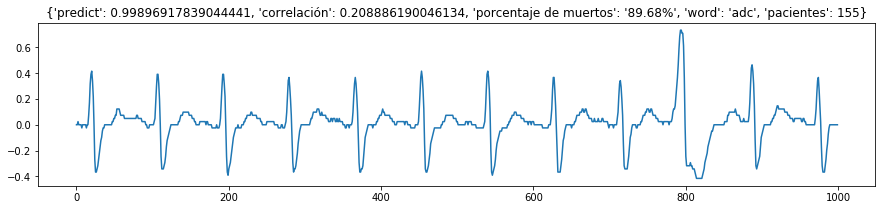

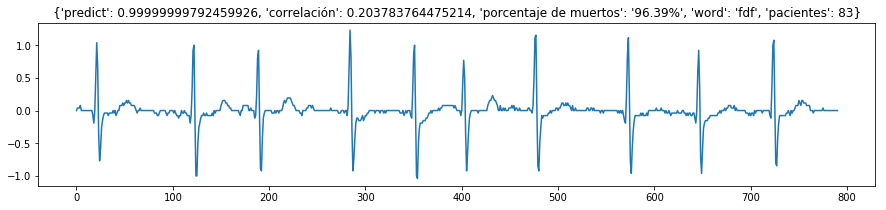

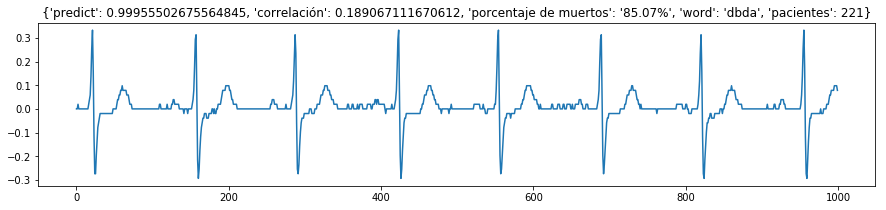

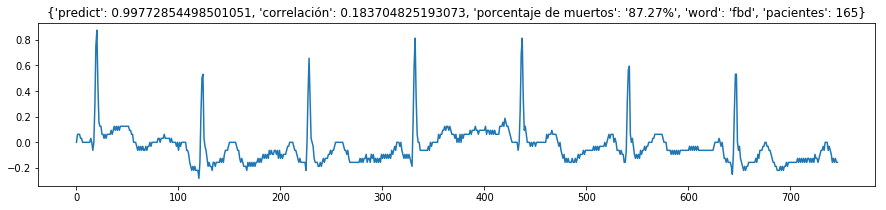

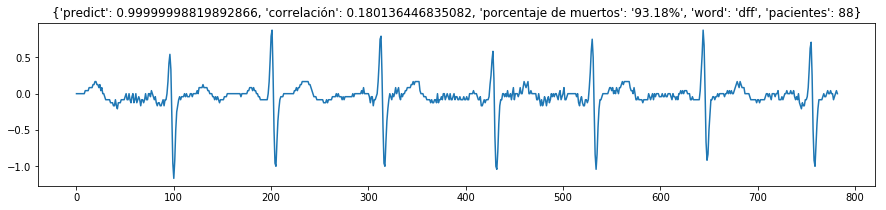

In [21]:
print("Top 5 HeartBeats con mayor probabilidad de muerte según la regresión logística")
plot_word(sortedBeats[:5])

In [22]:
from operator import itemgetter
from scipy.stats.stats import pearsonr
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

def find_pearson(value, patient, survived):
    pearsonList = []
    for i in range(value):
        patientpear = patient[:, i]
        pearson = pearsonr(patientpear, survived)
        pearsonList.append({'grupo':i,'correlación':pearson[0],'p-valor':pearson[1]})
    return sorted(pearsonList, key=itemgetter('correlación'), reverse=True)

sortedList = find_pearson(bestScore,patientnmf,survived)
#sortedList = sorted(pearsonList, key=itemgetter('p1'), reverse=True)
df = pd.DataFrame(sortedList)
df = df.set_index('grupo')
df = df.sort_values(['correlación'], ascending=[False])
df

,correlación,p-valor
grupo,,
21,0.13627,0.00130
17,0.09745,0.02180
13,0.08765,0.03917
3,0.08438,0.04712
14,0.08298,0.05094
22,0.07585,0.07446
16,0.07246,0.08842
25,0.07076,0.09615
4,0.06731,0.11352


In [23]:
columns = list(table)
components = bestNmf.components_
topword = print_top_words(components, columns,topic_index=sortedList[0]['grupo'])[0]['features']
subwords = []
for subword in topword:
    if subword['p1']>0:
        subwords.append(subword['word'])
print(str(subwords[:10]))

['adcd', 'aadc', 'aagh', 'badc', 'fga', 'ajda', 'gfaf', 'ffda', 'abbdd', 'fgf']


In [24]:
table = convert_matrix(sumvals=False,filter_words=tuple(subwords))
survived = table.index.labels[1].tolist()
patients = table.values
table

(540, 232)


,,aabadd,aabaf,aabafb,aabaga,aabbg,aabbgb,aabdad,aabdb,aabdbb,aacda,...,gfd,gff,gha,haf,hag,haj,hbf,hfa,hfg,hga
subject_id,isAlive,,,,,,,,,,,,,,,,,,,,,
135,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
151,1,1,0,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
177,1,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
214,1,0,1,0,1,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
279,1,0,0,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
283,1,1,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
368,1,0,1,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
377,1,1,1,1,1,0,0,1,1,1,0,...,1,0,0,1,0,0,0,1,0,0
408,1,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
patients_train, patients_test,survived_train, survived_test = train_test_split(patients,survived,test_size=0.2, random_state=42)
print(table.shape)
print(patients_train.shape)
print(patients_test.shape)

(540, 232)
(432, 232)
(108, 232)


In [26]:
model,acurracy = ajustLogisticRegression(patients_train,survived_train,patients_test,survived_test)

acurracy is 77.78%


In [27]:
logit_roc_auc = auc_model("Logistic",model,patients_test,survived_test)

Logistic AUC = 0.5002f


In [28]:
columns = list(table.columns.values)
pearsonList = []
for i in range(len(columns)):
    pearson = pearsonr(patients[:,i],survived)
    word = columns[i]
    count = countPatients(word)
    deadPatient,patient = count['deadPatient'],count['patient']
    percent = deadPatient/patient
    pearsonList.append({'word':word,'correlación':pearson[0],'p-valor':pearson[1],'pacientes muertos':"{0:.2%}".format(percent)+" de %d" %patient})

In [29]:
df = pd.DataFrame(pearsonList)
df = df.set_index('word')
df = df.sort_values(['correlación'], ascending=[False])
df

,correlación,p-valor,pacientes muertos
word,,,
adc,0.20630,0.00000,89.68% de 155
dbda,0.18111,0.00002,85.07% de 221
fbd,0.17845,0.00003,87.27% de 165
ffd,0.17579,0.00004,91.26% de 103
haf,0.17161,0.00006,95.45% de 66
addaba,0.17093,0.00007,90.57% de 106
gah,0.16856,0.00008,100.00% de 44
faf,0.16610,0.00011,87.01% de 154
fabd,0.16480,0.00012,90.29% de 103


In [30]:
print(components)
for compon in components:
    print(max(compon),compon.)

SyntaxError: invalid syntax (<ipython-input-30-81df37c64729>, line 3)